In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
norm_ = ['None','minmax','quantile']
brand=[0,1,2,3]
brand_num = 1 # change brand num 1,2,3  
norm_select = 1 # change norm ver. 


test_dict = np.load(f"./brand{brand[brand_num]}/{norm_[norm_select]}/test_scores.npy",allow_pickle=True).item()
train_dict = np.load(f"./brand{brand[brand_num]}/{norm_[norm_select]}/train_scores.npy",allow_pickle=True).item()
train_labels = np.load(f"./brand{brand[brand_num]}/{norm_[norm_select]}/train_labels_brand{brand[brand_num]}.npy",allow_pickle=True).item()
test_labels = np.load(f"./brand{brand[brand_num]}/{norm_[norm_select]}/test_labels_brand{brand[brand_num]}.npy",allow_pickle=True).item()

In [3]:
num_snippet_train = []
for k,v in train_dict.items():
    num_snippet_train.append(len(v))
print("Number of Snippet data : " ,num_snippet_train)
print("Total Train Snippet Data : ", sum(num_snippet_train))
num_snippet_test = []
for k,v in test_dict.items():
    num_snippet_test.append(len(v))
print("Number of Snippet data : " ,num_snippet_test)
print("Total Test Snippet Data : ",sum(num_snippet_test))

print((test_labels))
print((train_labels))

Number of Snippet data :  [5279, 5380, 1128, 6895, 6956, 3834, 659, 3250, 437, 3166, 3055, 3774, 5704, 4024, 2290, 847, 699, 498, 5143, 4404, 567, 1966, 3839, 1414, 2296, 5249, 4272, 4659, 7738, 1166, 1909, 4364, 3551, 6167, 708, 5456, 3343, 4044, 7211, 3309, 3997, 3445, 4150, 3385, 6483, 4921, 3865, 4380, 4399, 5831, 6516, 363, 6153, 3973, 8368, 7139, 5870, 3214, 2045, 6363, 852, 1506, 583, 2588, 6039, 6940, 4319, 810, 931, 3943, 4838, 971, 2021, 3398, 3040, 3767, 1505, 4291, 1153, 8341, 1047, 1077, 762, 1015, 708, 3622, 597, 4570, 2736, 1977, 3591, 1969, 4542, 631, 2905, 3956, 2610, 873, 3865, 2093, 573, 1229, 244, 1348, 1065, 1026, 781, 880, 1506, 1415, 2713, 744, 646, 731, 687, 865, 688, 502, 758, 857, 135, 841, 611, 1809, 877, 854, 330, 82, 71, 84, 84, 28, 40, 51, 11, 5450, 4217, 1022, 6858, 5535, 4660, 1020, 2456, 2074, 3329, 659, 4028, 3881, 740, 5057, 1042, 727]
Total Train Snippet Data :  420413
Number of Snippet data :  [3579, 703, 727, 4293, 197, 3402, 2419, 6, 1554, 2660, 5

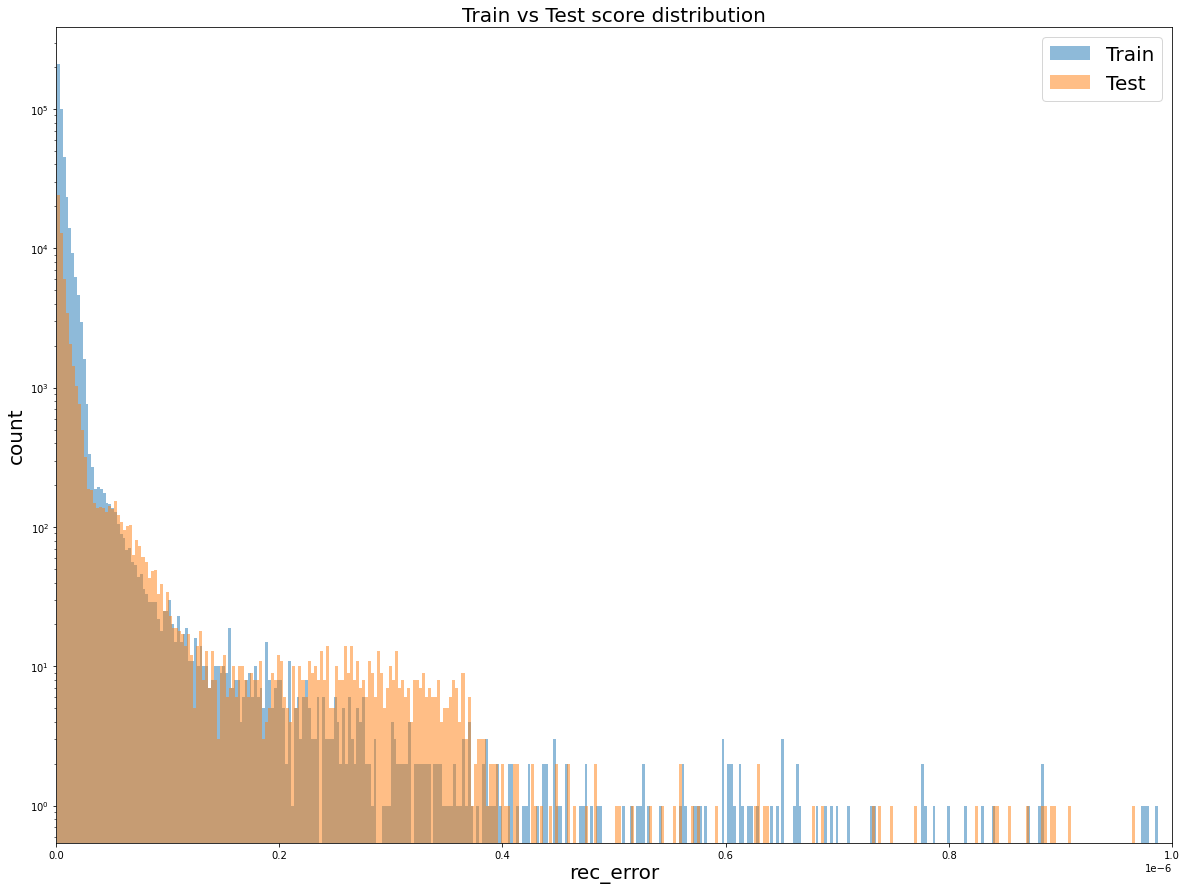

In [8]:
train_scores = np.log(1+np.concatenate(list(train_dict.values())))
test_scores  = np.log(1+np.concatenate(list(test_dict.values())))

plt.figure(figsize=(20,15))
plt.xlim(0,0.000001)
plt.yscale('log')
plt.hist(train_scores, bins=1000, alpha=0.5, label="Train")
plt.hist(test_scores,  bins=1000, alpha=0.5, label="Test")
plt.legend(fontsize=20)
plt.xlabel("rec_error",fontsize=20)
plt.ylabel("count",fontsize=20)
plt.title("Train vs Test score distribution",fontsize=20)
plt.show()

In [9]:
import pandas as pd
import numpy as np

rows = []

for car_id, errs in train_dict.items():
    for e in np.atleast_1d(errs):
        rows.append({
            "split": "train",
            "car": car_id,
            "rec_error": float(e),
        })

for car_id, errs in test_dict.items():
    for e in np.atleast_1d(errs):
        rows.append({
            "split": "test",
            "car": car_id,
            "rec_error": float(e),
        })

df = pd.DataFrame(rows)
print(df.head())


train_labels.update(test_labels)
car_label= train_labels
df["label_car"] = df["car"].map(car_label)  # 없으면 NaN


   split  car     rec_error
0  train   64  6.113377e-09
1  train   64  5.985197e-09
2  train   64  1.989414e-09
3  train   64  3.997274e-09
4  train   64  1.618898e-09


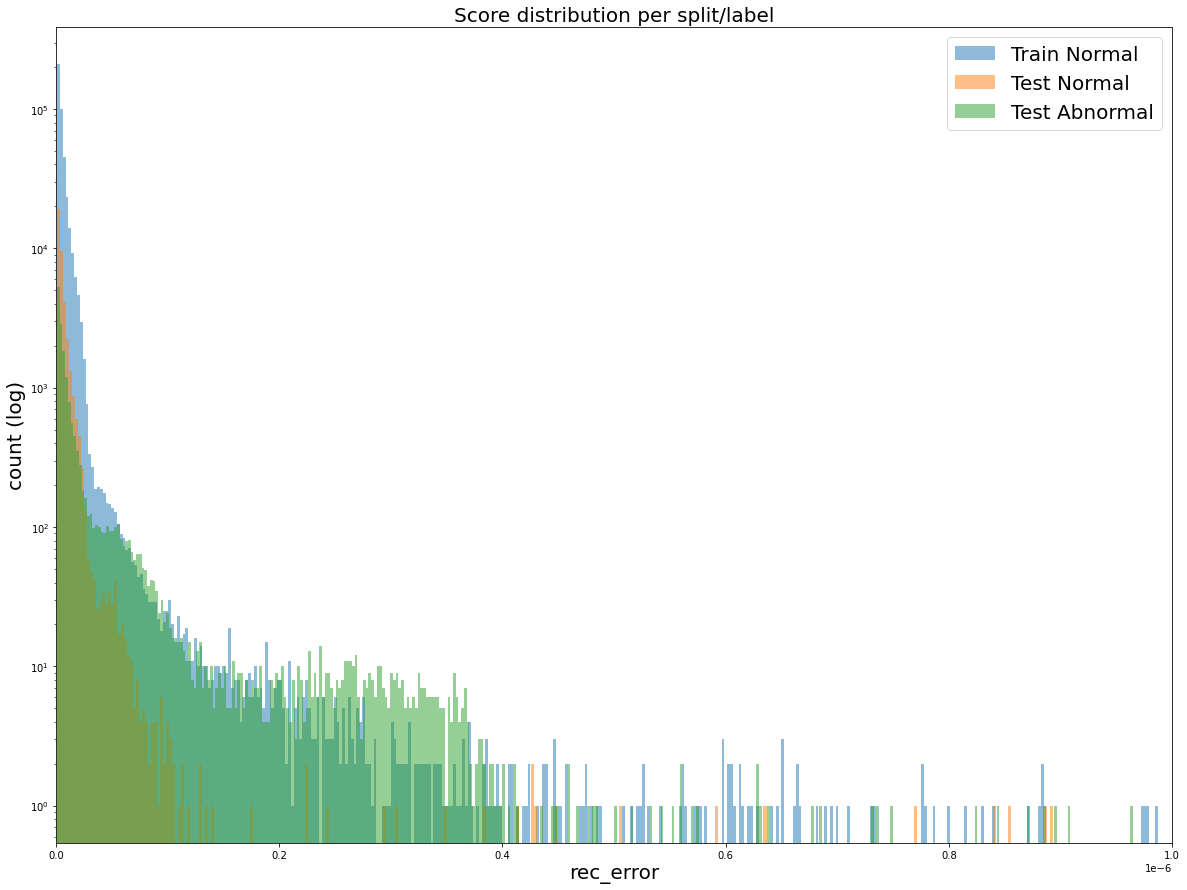

In [10]:
train_scores  = df.query("split == 'train' and label_car == 0")["rec_error"].values
test_norm     = (df.query("split == 'test' and label_car == 0")["rec_error"].values)
test_abn      = (df.query("split == 'test' and label_car == 1")["rec_error"].values)

plt.figure(figsize=(20,15))
plt.xlim(0,0.000001)
plt.yscale('log')
plt.hist(train_scores, bins=1000, alpha=0.5, label="Train Normal")
plt.hist(test_norm, bins=1000, alpha=0.5, label="Test Normal")
plt.hist(test_abn, bins=1000, alpha=0.5, label="Test Abnormal")
plt.legend(fontsize=20)
plt.xlabel("rec_error",fontsize=20)
plt.ylabel("count (log)",fontsize=20)
plt.title("Score distribution per split/label",fontsize=20)
plt.show()

In [11]:
car_mean = {}
car_max  = {}

for car_id, errs in test_dict.items():
    errs = (np.atleast_1d(errs))
    car_mean[car_id] = float(errs.mean())
    car_max[car_id]  = float(errs.max())

from sklearn.metrics import roc_auc_score

test_car_ids = list(test_dict.keys())
y_true = np.array([car_label[c] for c in test_car_ids])
y_score_mean = np.array([car_mean[c] for c in test_car_ids])
y_score_max  = np.array([car_max[c]  for c in test_car_ids])

print("AUROC (mean):", roc_auc_score(y_true, y_score_mean))
print("AUROC (max):",  roc_auc_score(y_true, y_score_max))



AUROC (mean): 0.7770833333333333
AUROC (max): 0.5916666666666668
